# Hyperparameters

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import time

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as plotly_colors
import plotly.figure_factory as ff
from plotly.io import renderers
renderers.default = 'png'

from utils.design import plotly_main_layout, plotly_main_subplot_layout

___
### Data Normalization

In [54]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';')

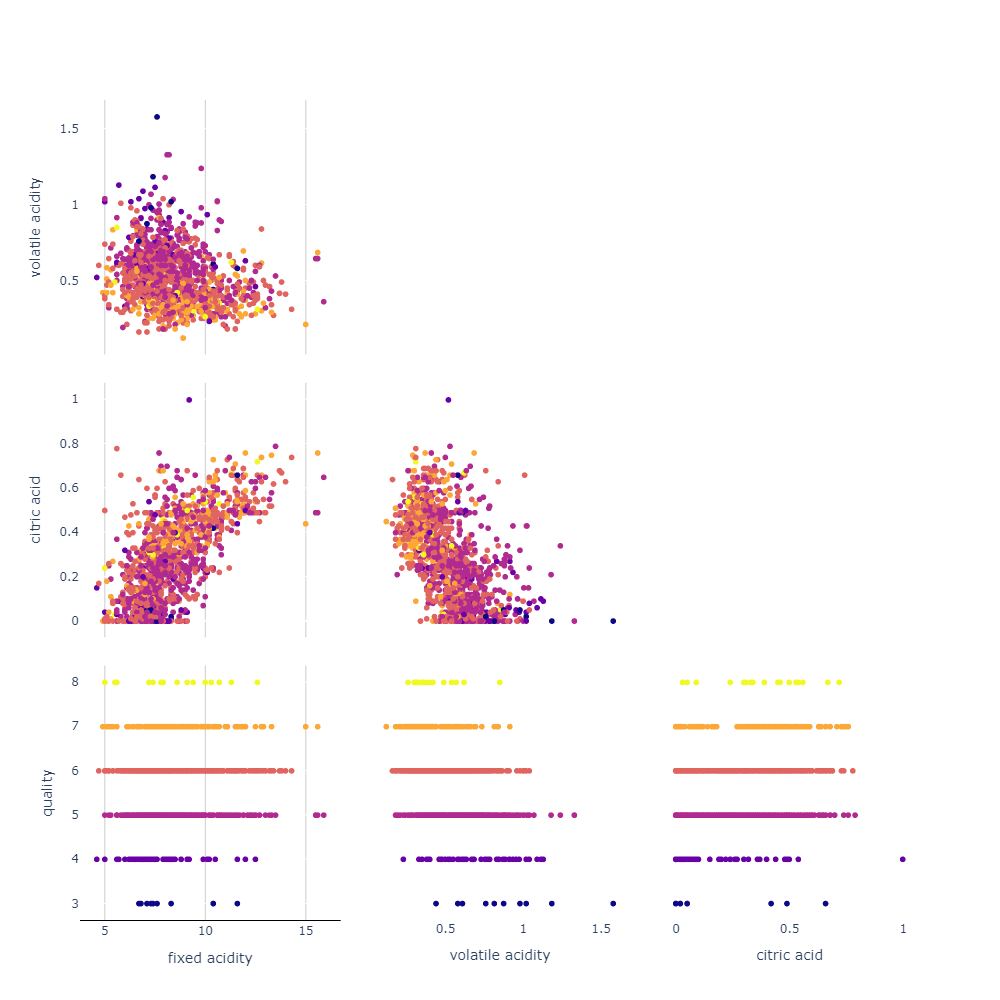

In [50]:
fig = go.Figure()
fig.add_trace(go.Splom(
    dimensions=[
        dict(label="fixed acidity", values=data["fixed acidity"]),
        dict(label="volatile acidity", values=data["volatile acidity"]),
        dict(label="citric acid", values=data["citric acid"]),
        dict(label="quality", values=data["quality"]),
    ],
    marker=dict(color=data['quality'], showscale=False,),
    diagonal=dict(visible=False), showupperhalf=False,
))
plotly_main_layout(fig, width=1000, height=1000, x='fixed acidity',)

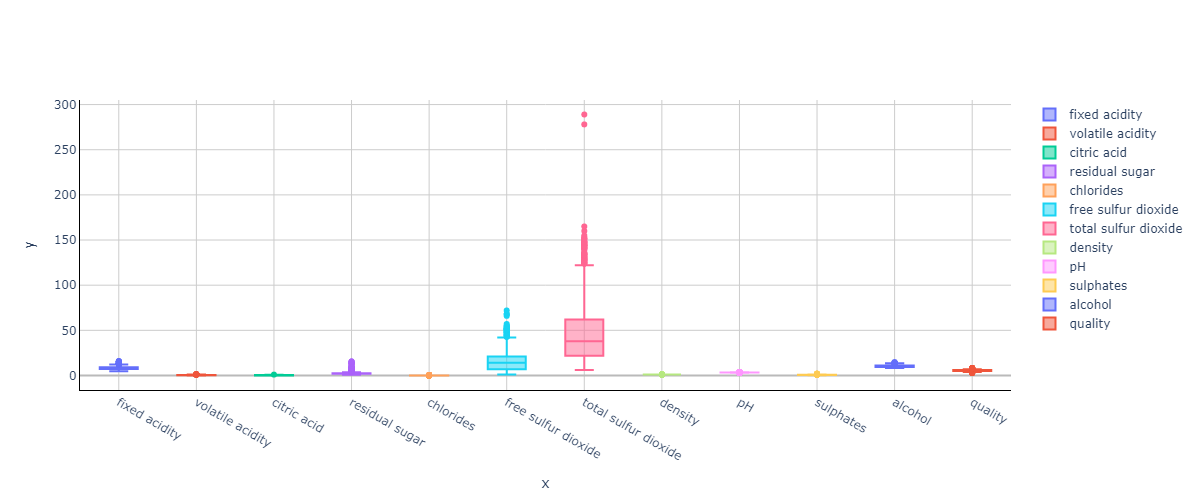

In [ ]:
fig = go.Figure()
for column in data.columns:
    fig.add_trace(go.Box(
        y=data[column], name=column, boxpoints='outliers'
    ))
fig.update_layout(
    width=1700, height=400, xaxis_tickangle=45
)
plotly_main_layout(fig, width=1200, height=500)

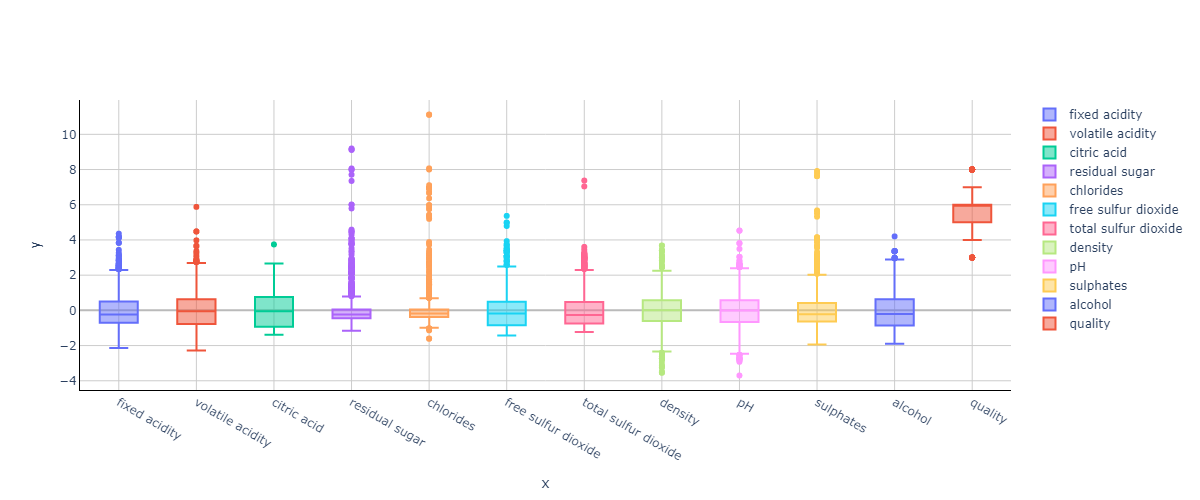

In [56]:
for col in [col for col in data.columns if col != 'quality']:
    data[col] = stats.zscore(data[col])
fig = go.Figure()
for column in data.columns:
    fig.add_trace(go.Box(
        y=data[column], name=column, boxpoints='outliers'
    ))
fig.update_layout(
    width=1700, height=400, xaxis_tickangle=45
)
plotly_main_layout(fig, width=1200, height=500)

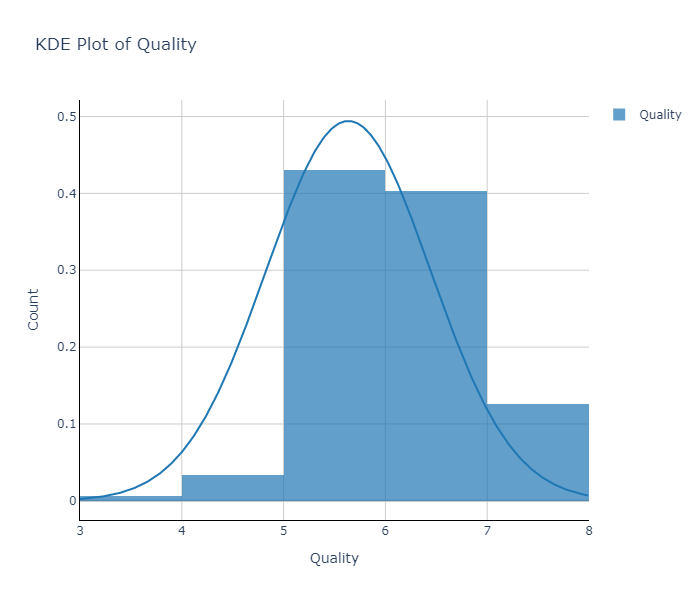

In [73]:
fig = ff.create_distplot([data['quality']], ['Quality'], show_hist=True, show_rug=False, curve_type='normal')
plotly_main_layout(fig, title='KDE Plot of Quality', x='Quality', y='Count')
fig.show()

data['boolQuality'] = 0
data['boolQuality'] = data['quality'].apply(lambda x: 1 if x > 5 else 0)

In [82]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor(data[[col for col in data.columns if column not in ['quality', 'boolQuality']]].values).float()
labels = torch.tensor(data['boolQuality'].values).float()

# we'll actually need the labels to be a "tensor"
labels = labels[:,None]
print('Label Shape:')
print(labels.shape, '\n')
     
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

train_data = TensorDataset(train_data, train_labels)
test_data  = TensorDataset(test_data, test_labels)

batchsize    = 64
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
     
print('Loader Shape:')
for X,y in train_loader:
  print(X.shape,y.shape)

Label Shape:
torch.Size([1599, 1]) 

Loader Shape:
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])


___
### Normalization

- Motivation: 
    - $\hat{y} = \sigma(\textbf{x}^\text{T}\textbf{w})$
    - $\textbf{w} \leftarrow \textbf{w} - \eta d\mathcal{L}$
- Z-Transform:
    - $z_i = \dfrac{x_i - \bar{x}}{\sigma}$
- Min-Max:
    - $\tilde{x} = \dfrac{x - \text{min }x}{\text{max }x - \text{min }x}$
    - $x^* = a + \tilde{x}(b-a)$
> ##### Batch (Layer) Normalization
> - It is the processos of normalizing inputs of each deep layer, not only the input one
>    - This avoid covariance shifts (shifts of the activation distributions characteristics), and gradients vanishing or exploding
>    - $\tilde{\textbf{x}} = \gamma \textbf{x} + \beta$
>    - $\hat{y} = \sigma(\tilde{\textbf{x}}^\text{T}\textbf{w})$
>        - $\gamma$: scaling parameter
>        - $\beta$: shifting parameter
> - It should be switched off during test/evaluation, because the batch size can differ
    

###### _______________________
#### Z-Transform

In [90]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
data = data[data['total sulfur dioxide'] < 200] # drop a few outliers

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data.loc[:,cols2zscore] = data[cols2zscore].apply(stats.zscore)

data.loc[:,'boolQuality'] = 0
data.loc[data['quality'] > 5,'boolQuality'] = 1

In [91]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:, None] # transform to matrix
     
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset  = TensorDataset(test_data, test_labels)

In [92]:
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        ### input layer
        self.input = nn.Linear(11,16)

        ### hidden layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        ### output layer
        self.output = nn.Linear(32,1)

    # forward pass
    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

In [ ]:
def trainTheModel(numepochs=1000):

    # loss function and optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr=.01)

    # initialize losses
    losses   = torch.zeros(numepochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(numepochs):

        # switch on training mode
        winenet.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            batchAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        winenet.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = winenet(X)
        testAcc.append(100*torch.mean(((yHat>0) == y).float()).item())
      
    # function output
    return trainAcc,testAcc,losses

In [ ]:
numepochs = 800

# range of batch sizes
batchsizes = 2**np.arange(1,10,2)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(batchsizes)))
accuracyResultsTest  = np.zeros((numepochs, len(batchsizes)))
comptime             = np.zeros(len(batchsizes))

# test data doesn't vary by training batch size
test_loader = DataLoader(test_dataDataset, batch_size=test_dataDataset.tensors[0].shape[0])

# loop over batch sizes
for bi in range(len(batchsizes)):

    # start the clock!
    starttime = time.process_time()

    # create dataloader object
    train_loader = DataLoader(train_dataDataset, batch_size=int(batchsizes[bi]), shuffle=True, drop_last=True)

    # create and train a model
    winenet = ANNwine()
    trainAcc, testAcc, losses = trainTheModel(numepochs)

    # store data
    accuracyResultsTrain[:,bi] = trainAcc
    accuracyResultsTest[:,bi]  = testAcc

    # check the timer
    comptime[bi] = time.process_time() - starttime

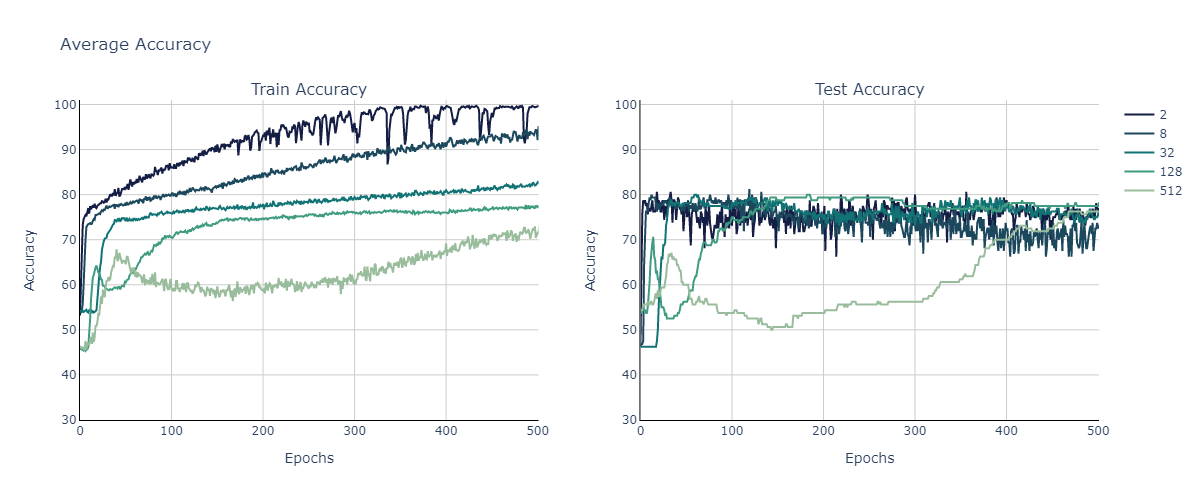

In [107]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Train Accuracy', 'Test Accuracy'])

colors = plotly_colors.cmocean.curl[:len(batchsizes)]

for i, (acc_label, color) in enumerate(zip(batchsizes, colors)):
    fig.add_trace(go.Scatter(
        x=list(range(numepochs)), y=accuracyResultsTrain[:, i], 
        name=f'{acc_label}', mode='lines', line=dict(color=color)
    ), row=1, col=1)

# Plot Test Accuracy using same colors
for i, (acc_label, color) in enumerate(zip(batchsizes, colors)):
    fig.add_trace(go.Scatter(
        x=list(range(numepochs)), y=accuracyResultsTest[:, i], 
        name=f'{acc_label}', mode='lines',line=dict(color=color), showlegend=False  
    ), row=1, col=2)

plotly_main_subplot_layout(fig, title='Average Accuracy', x='Epochs', y='Accuracy', width=1200, height=500, x_range=[0, 501], y_range=[30, 101])

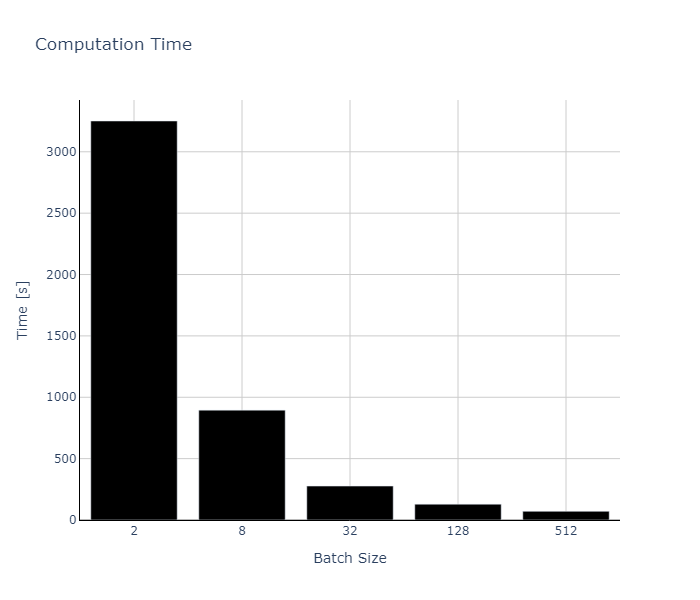

In [99]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=[str(i) for i in batchsizes], y=comptime, marker=dict(color='black')
))
plotly_main_layout(fig, title='Computation Time', x='Batch Size', y='Time [s]')

###### _______________________
#### Batch Normalization

In [119]:
class ANNwine_BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(11, 16)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(16, 32)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 20)
        self.output = nn.Linear(20, 1)


    def forward(self, x, doBatchNorm):
        x = F.relu(self.input(x))

        if doBatchNorm:
            x = self.batch_norm1(x)
            x = F.relu(self.fc1(x))
            x = self.batch_norm2(x)
            x = F.relu(self.fc2(x))
        else:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

        x = self.output(x)
        return x

In [124]:
def trainTheModel(numepochs:int=1000, doBatchNorm:bool=True):
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr=0.01)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):
        winenet.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:
            yHat = winenet(X, doBatchNorm)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        winenet.eval()
        X, y = next(iter(test_loader)) 
        with torch.no_grad():
            yHat = winenet(X, doBatchNorm)
        testAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())
  
    # function output
    return trainAcc, testAcc, losses

In [ ]:
winenet = ANNwine_BatchNorm()
trainAccNo, testAccNo, lossesNo = trainTheModel(doBatchNorm=False)

winenet = ANNwine_BatchNorm()
trainAccYes, testAccYes, lossesYes = trainTheModel(doBatchNorm=True)

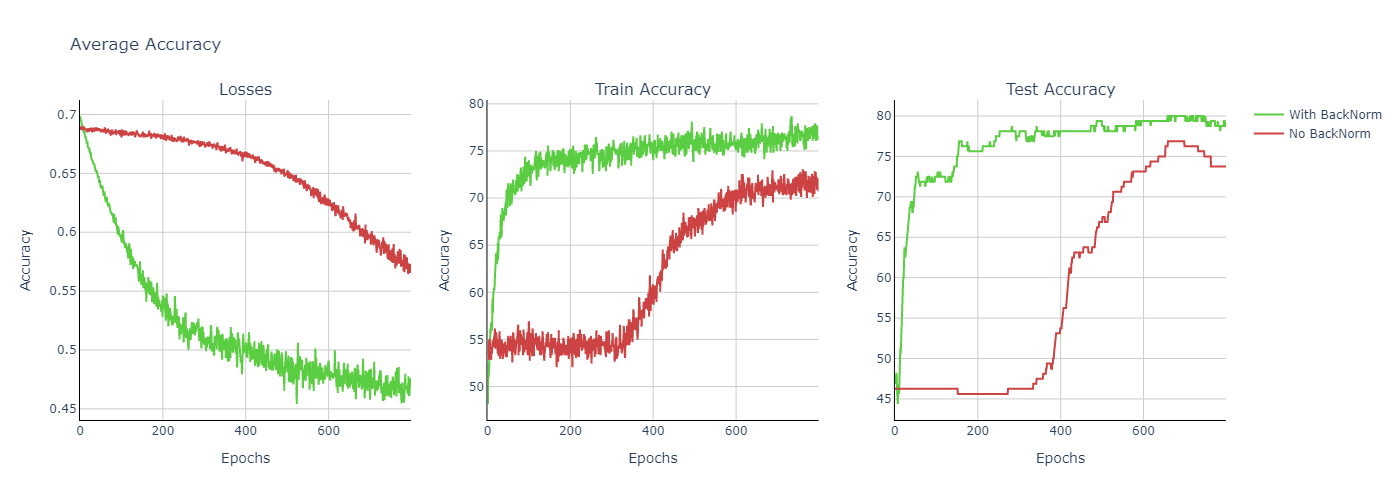

In [143]:
fig = make_subplots(rows=1, cols=3, subplot_titles=['Losses', 'Train Accuracy', 'Test Accuracy'])

fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=lossesYes, 
    name=f'With BackNorm', mode='lines', line=dict(color='#5bcd42')
), row=1, col=1)
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=lossesNo, 
    name=f'No BackNorm', mode='lines',line=dict(color='#cd4242')
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=trainAccYes, mode='lines', line=dict(color='#5bcd42'), showlegend=False
), row=1, col=2)
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=trainAccNo, mode='lines',line=dict(color='#cd4242'), showlegend=False
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=testAccYes, mode='lines', line=dict(color='#5bcd42'), showlegend=False
), row=1, col=3)
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=testAccNo, mode='lines',line=dict(color='#cd4242'), showlegend=False
), row=1, col=3)

plotly_main_subplot_layout(fig, title='Average Accuracy', x='Epochs', y='Accuracy', width=1400, height=500,)

___
### Activation Functions

- All deep learning model can be reduced to a linear regression without activation functions
> ##### ReLU
> - $\sigma(x) = \max(0,x)$
> - Characteristics:
>     - Strongly nonlinear
>     - Never saturates
>     - Biased average
>     - Great for Hidden
> - Hidden Layers:
>     - Nonlinearities
>     - Necessity for computational simplicity
>     - Avoiding limited ranges
>     - Avoid gradient vanishing and explosion
> - Output Layers:
>     - Nonlinear (classify) and Linear (regression)
>     - Boundaries of saturations that can be converted to probabilities

> ##### Leaky ReLU
> - $\sigma(x) = \max(ax,x), \quad (\text{tipical } \alpha=0.1)$
> - Characteristics:
>     - Strongly nonlinear
>     - Never saturates
>     - Less bias average
>     - Allows negative activations

> ##### Leaky-N
> - $\sigma(x) = \min(N,\max(0,x)), \quad (\text{tipical } N=6)$
> - Characteristics:
>     - Strongly nonlinear
>     - Saturates
>     - Avoids blowing up

> ##### Sigmoid
> - $\sigma(x) = \dfrac{1}{1+e^{-x}}$
> - Characteristics:
>     - Nearly linear
>     - Saturates at [0, 1]
>     - Biased average ($\mu = 0.5$)
>     - Great for Ouput

> ##### Tanh
> - $\sigma(x) = \dfrac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$
> - Characteristics:
>     - Nearly linear in range
>     - Saturates at [-1, 1]
>     - Unbiased average
>     - Ok for Ouput

In [172]:
x = torch.linspace(-3, 3, 101)

def NNoutputx(actfun):
    actfun = getattr(torch.nn, actfun)
    return actfun()

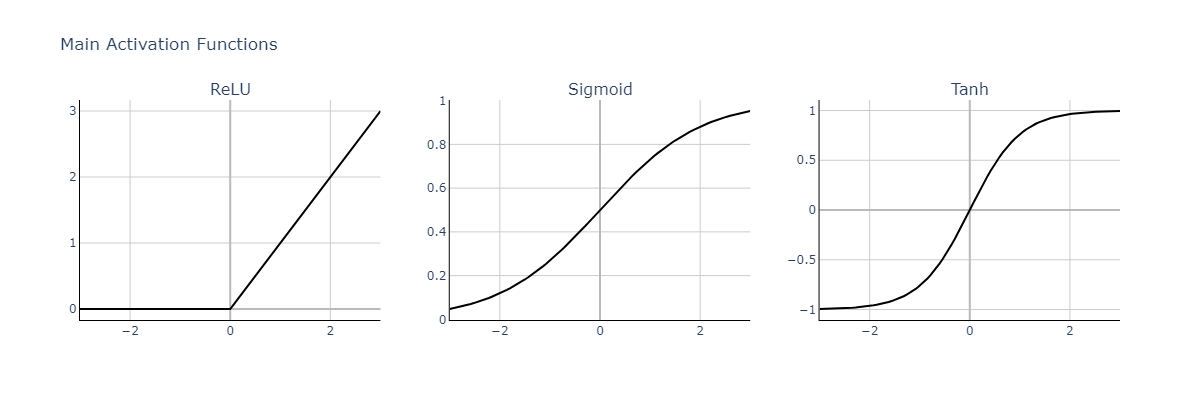

In [173]:
actfun = ['ReLU', 'Sigmoid', 'Tanh']

fig = make_subplots(rows=1, cols=3, subplot_titles=actfun)

for i, fun in enumerate(actfun):
    fig.add_trace(go.Scatter(
        x=x, y=NNoutputx(fun)(x), mode='lines', line=dict(color='black'), showlegend=False
    ), row=1, col=i+1)

plotly_main_subplot_layout(fig, title='Main Activation Functions', width=1200, height=400,)

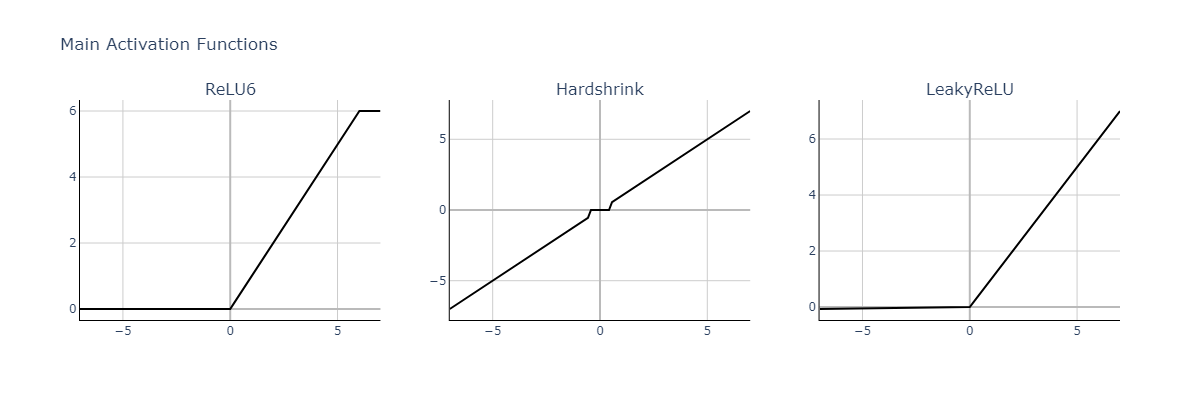

In [174]:
actfun = ['ReLU6', 'Hardshrink', 'LeakyReLU']
x = torch.linspace(-7, 7, 101)

fig = make_subplots(rows=1, cols=3, subplot_titles=actfun)

for i, fun in enumerate(actfun):
    fig.add_trace(go.Scatter(
        x=x, y=NNoutputx(fun)(x), mode='lines', line=dict(color='black'), showlegend=False
    ), row=1, col=i+1)

plotly_main_subplot_layout(fig, title='Main Activation Functions', width=1200, height=400,)

In [188]:
class ANNwine(nn.Module):
    def __init__(self, actfun):
        super().__init__()

        self.input = nn.Linear(11, 16)
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 20)
        self.output = nn.Linear(20, 1)

        actfun = getattr(nn, actfun)()
        self.actfun = actfun

    def forward(self, x):
        x = self.actfun(self.input(x))
        x = self.actfun(self.fc1(x))
        x = self.actfun(self.fc2(x))
        x = self.output(x)
        return x
    

def trainTheModel(numepochs:int=1000):
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(widenet.parameters(), lr=0.01)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):
        widenet.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:
            yHat = widenet(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        widenet.eval()
        X, y = next(iter(test_loader)) 
        with torch.no_grad():
            yHat = widenet(X)
        testAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())
  
    # function output
    return trainAcc, testAcc, losses

In [189]:
act_functions = ['ReLU', 'Sigmoid', 'Tanh', 'ReLU6', 'Hardshrink', 'LeakyReLU']

numepochs = 800
trainByAct = np.zeros((numepochs, len(act_functions)))
testByAct = np.zeros((numepochs, len(act_functions)))

for ai, act_function in enumerate(act_functions):
    widenet = ANNwine(actfun=act_function)
    trainByAct[:,ai], testByAct[:,ai], losses = trainTheModel(numepochs=numepochs)

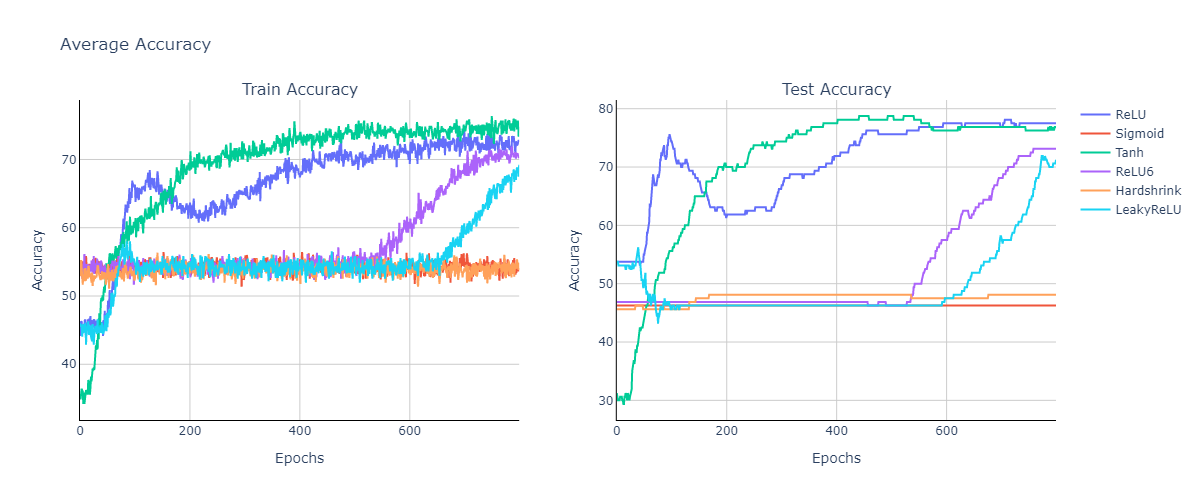

In [202]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Train Accuracy', 'Test Accuracy'])

colors = plotly_colors.qualitative.Plotly[:len(act_functions)]

for i, (acc_label, color) in enumerate(zip(act_functions, colors)):
    fig.add_trace(go.Scatter(
        x=list(range(numepochs)), y=trainByAct[:, i], 
        name=f'{acc_label}', mode='lines', line=dict(color=color)
    ), row=1, col=1)

# Plot Test Accuracy using same colors
for i, (acc_label, color) in enumerate(zip(act_functions, colors)):
    fig.add_trace(go.Scatter(
        x=list(range(numepochs)), y=testByAct[:, i], 
        name=f'{acc_label}', mode='lines',line=dict(color=color), showlegend=False  
    ), row=1, col=2)

plotly_main_subplot_layout(fig, title='Average Accuracy', x='Epochs', y='Accuracy', width=1200, height=500,)

___
### Loss Functions


- Motivation: 
    - $\hat{y} = \sigma(\textbf{x}^\text{T}\textbf{w})$
    - $\textbf{w} \leftarrow \textbf{w} - \eta d\mathcal{L}$

    
> ##### MSE
> - $\mathcal{L} = \dfrac{1}{2}(\hat{y}-y)^2$
> - Used for continuous data when the output is a numerical prediction
> - Linear activation function

> ##### Cross-Entropy (Logistic or BCE)
> - $\mathcal{L} = -(y\log(\hat{y}) + (1+y)\log(1-\hat{y}))$
> - Used for binary categorical data when the output is a probability
> - Sigmoid activation function

> ##### Log-Likelihood (N-way or CCE)
> - $\mathcal{L} = -\sum_{i=1}^{N}\sum_{k=1}^C = y_i^{(k)} \log(\hat{y}_i^{(k)})$
> - Used for categorical data with one-hot encoding
> - Softmax activation function

> ##### Kullback-Leibler Divergence
> - $\mathcal{L} = -\sum_{z}p(x)\log\left( \dfrac{p(x)}{q(x)} \right)$
> - Measures the "distance" between two probability distributions

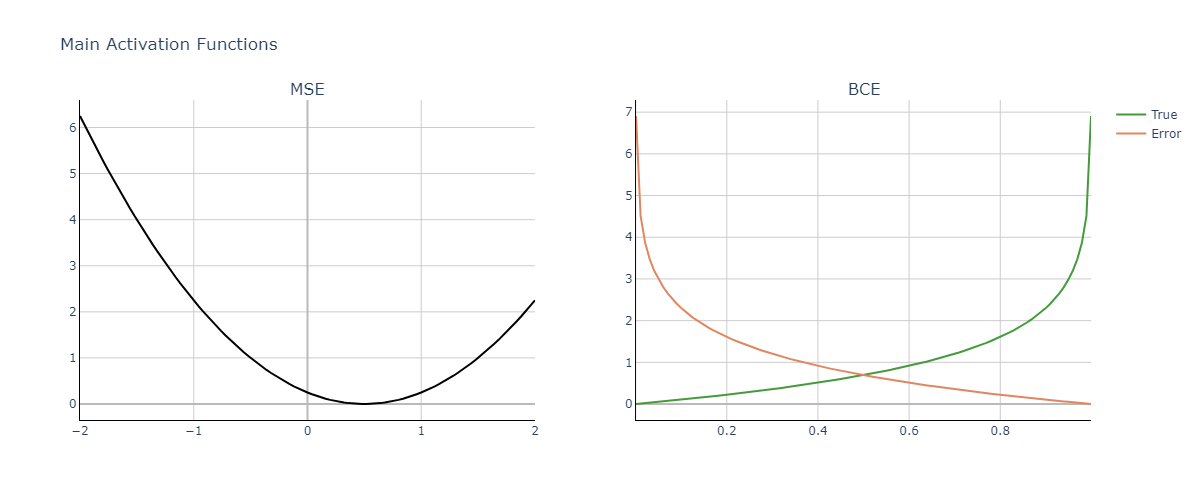

In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['MSE', 'BCE'])

lossfunMSE = nn.MSELoss()
yHat = torch.linspace(-2,2,101)
y = torch.tensor(.5)

L = np.zeros(101)
for i,yy in enumerate(yHat):
  L[i] = lossfunMSE(yy,y)

fig.add_trace(go.Scatter(
    x=yHat, y=L, mode='lines', line=dict(color='black'), showlegend=False
), row=1, col=1)


lossfunBCE = nn.BCELoss()
yHat = torch.linspace(.001,.999,101)
y1 = torch.tensor(0.)
y2 = torch.tensor(1.)

L = np.zeros((101,2))
for i,yy in enumerate(yHat):
  L[i,0] = lossfunBCE(yy,y1)
  L[i,1] = lossfunBCE(yy,y2)

fig.add_trace(go.Scatter(
    x=yHat, y=L[:,0], mode='lines', line=dict(color='#459b3b'), name='True'
), row=1, col=2)
fig.add_trace(go.Scatter(
    x=yHat, y=L[:,1], mode='lines', line=dict(color='#e08761'), name='Error'
), row=1, col=2)

plotly_main_subplot_layout(fig, title='Main Activation Functions', width=1200, height=500,)

In [ ]:
class myLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        loss = torch.abs(x-y)
        return loss

myloss = myLoss()
print(myloss(torch.tensor(4), torch.tensor(5)))

tensor(1)


___
### Optimizers

- Are algorithms that adjusts the weights during backpropagation
- Other optimizers are simply modifications of the SGD

> ##### Stochastic Gradient Descent
> - $\textbf{w} \leftarrow \textbf{w} - \eta d\mathcal{L}$
> - Changes the weights after each sample, being great when all samples are really similar to each other
> - It is very sensible to outliers

> ##### Mini-Batch SGD
> - $\textbf{w} \leftarrow \textbf{w} - \eta d\mathcal{J}$
> - Changes the weights after N samples, avereging the loss achoss those samples
> - Can be more robust, except when samples are similar to each other

> ##### Momentum
> - $v_t = (1-\beta)v_t + \beta v_{t-1}, \quad \beta \in \{ 0, 1 \}$
> - This smoothes via weighted average
> - Each data point is a weight combination of itself and the previous data point
> - 
> - 
> - 

###### _______________________
#### Z-Transform

###### _______________________
#### Z-Transform

___
### x

___
### x

___
### x

___
### x

___
### x